## Prerequisites

In [2]:
import numpy as np
import matplotlib.pyplot

from scipy.fftpack import fft, ifft, fftfreq
from scipy import signal as sig
from scipy.ndimage.filters import gaussian_filter1d, gaussian_filter
from scipy.stats import binned_statistic, entropy, norm, zscore
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)
plt.rcParams['figure.figsize'] = (10, 6)

from fooof import FOOOF

In [3]:
#!pip install mne
from mne.filter import filter_data
#!pip install pyEDFlib
import pyedflib
#!pip install ipympl

#!pip install tensorpac
#!pip install joblib
import tensorpac

## Steps to implement

0. Defining LFP (PSD, filtering) functions

1. Data preprocessing:

> Reading channels of interest

> Downsampling to 2kHz

> Creating LFP instances

> BP IIR filter around 1-500 Hz

> Notch filter 50 Hz Harmonics

2. PAC algorithm (will work with lfp.data not lfp instance!)

> Defining parameters:
- Time range of interest (large time-window)
- Spectral range of interest for f_p and f_a -> Subdivision of range of f_a by 20 centers (log or linear)
- Length of the small sliding time-window + overlap (>1 cycle of f_p_min)
- PSD (FFT) params
- Peak detection params

> For each f_A centre frequency:
- x(t) - bp filter (filtftilt, even-order, non-causal FIR), bw = max(f_p_max, step_f_A) (full-length signal!)
- Hilbert -> A(t) (amplitude envelope of filtered signal around f_A)

 > For each small time window:
 - Getting the *P_A - PSD of A(t) -- magnitude of FFT* in the current time window
 - Getting the *P_x - PSD of x(t)* in the current time window
 - Getting the highest peak of P_A (if PAC - should be a peak around f_p) (in f_p range of interest +- f_p_step (1 point))
 - Getting the peaks in PSD of P_x - confirming peak around f_p: (in f_p range of interest!)
 - Ignoring peaks which are <10% of the magnitude of the highest peak
// Best candidate for f_p* should be highest peak of P_A coinciding with the peak of P_x. Peak coincidence tolerance theshold = max(1.5Hz, spectrum resolution (1/length(time_window)//
 - If no actual peak or peak coincidence is found -> coupling = 0, f_p = arbitrary value (outside of range of interest)
 -

Симулировать сигнал, посчитать PAC разными методами. Посмотреть зависимость от времени

In [3]:
def get_psd(signal, sf, freq_range=(3, 17), log=False, smooth=False, sigma=4):
    
        n = len(signal)
        
        assert freq_range[1] <= sf
        
        if freq_range[0] <= sf/n:
            left = 0
        else:
            m = np.ceil(sf/freq_range[0])
            left = int(n/m - 1)
            
        if freq_range[1] == sf:
            right = n - 1
        else:
            m = np.ceil(sf/freq_range[1])
            right = int(n/m - 1)
            
        freqs = np.linspace(sf/n, sf, n)
        
        psd = abs(fft(signal)[left:right])
        if smooth:
            psd = gaussian_filter1d(psd, sigma=sigma)
        if log:
            psd = np.log10(psd)
        return freqs[left:right], psd

## Main tPAC function

In [6]:
# predefine time range of interest before putting signals into function
def calculate_tpac(phase_signal, 
                   amplitude_signal=None,
                   sf=2000,
                   fp_range=(3, 17), 
                   fa_range=(60, 440), 
                   time_window=2, 
                   overlap=1, 
                   padding=2, 
                   full_cycles_fp='phase_based',
                   **fooof_kwargs):
    """
    Time range for signals needs to be predefined, it is better to use whole number of time_windows
    **Returns**
    - Coupling strength over time: PAC(t) for each amplitude giving frequency (hfo or f_a)
    - Preffered phase-giving frequency f_p(t)
    **Parameters**
    phase_signal: phase_giving signal or signal if amplitude_signal is None
    amplitude_signal: amplitude_giving signal. if None phase_signal is used both for phase and amplitude. 
    Must be the same length as the phase_signal
    sf: sampling_frequency
    fp_range: beta_freqs of interests, ends included
    fa_range: ...
    time_window: sliding small time window (in secs). Must be > 1/beta_range[0]
    overlap: overlap in seconds
    padding: adding N seconds to the start and end of the signal (random noise)
    full_cycles_fp: either "fp_based" (n_cycles of fp) or "phase_based" (last occurence of initial phase)
    find_peaks_kwargs: arguments for scipy.signal.find_peaks - recommended prominence=400, width=2
    """

    if amplitude_signal is None:
        amplitude_signal = phase_signal.copy()

    assert len(amplitude_signal) == len(phase_signal), "Phase and amplitude giving signals must be of same length!"

    # changing units from sec to timepoints
    time_window = int(time_window * sf)
    overlap = int(overlap * sf)

    fa_freqs = np.linspace(*fa_range, 20)
    fa_step = fa_freqs[1] - fa_freqs[0]

    # len_signal/(window - overlap)
    n_timepoints = int(np.floor(len(phase_signal)/(time_window - overlap)))
    print("timepoints: ", n_timepoints)
    n_fa_freqs = 20

    ## applying padding ##
    pad_length = 0
    
    if padding != 0:
        pad_length = padding * sf
        pad = np.random.normal(pad_length)
        amplitude_signal = np.hstack([pad, amplitude_signal, pad])
        phase_signal = np.hstack([pad, phase_signal, pad])
        
        # immediately delete padding as it is useless here
        phase_signal = phase_signal[pad_length:-pad_length]

    # initializing output arrays
    tpac_matrix = np.zeros((n_fa_freqs, n_timepoints))
    fp_dynamics = np.zeros((n_fa_freqs, n_timepoints))
    phase_dynamics = np.zeros((n_fa_freqs, n_timepoints))

    for i in range(n_fa_freqs):

        ### bandpass filtering amplitude giving signal around current f_a ###

        fa = fa_freqs[n_fa_freqs - i - 1] # to make it count large freqs first for good picture
        #print("Starting tPAC estimation for f_A={}".format(fa))
        fa_bw = max(fa_step, fp_range[1])
        fa_low_freq = fa - fa_bw/2
        fa_high_freq = fa + fa_bw/2
        
        # filtering amplitude giving signal with non-causal, zero-phase shift, FIR filter
        fa_filtered_data = filter_data(amplitude_signal, sf, fa_low_freq, fa_high_freq, verbose=False)

        # if padding was not set to zero, cut the edges after filtering
        if padding != 0:
            fa_filtered_data = fa_filtered_data[pad_length:-pad_length]
        
        assert len(fa_filtered_data) == len(phase_signal), "Length of the phase and amplitude signals must be the same after pad deletion"
        assert(len(fa_filtered_data)) != 0, "Filtered fa signal is zero!"
        
        ## getting the amplitude envelope using Hilbert transform ##
        amplitude_envelope = np.abs(sig.hilbert(fa_filtered_data))
        
        for t in range(n_timepoints):

            ## windowing amplitude envelope and phase giving signal to further compute PSDs ##
            if t == 0:
                start = 0
                stop = time_window
            else:
                start = t * (time_window - overlap)
                stop = start + time_window
                
            if (start + time_window) > len(amplitude_envelope):
                break
                
            #if i == 0:   
                #print("Timepoint # {}, [{}, {}] sec".format(t, start/sf, stop/sf))   

            windowed_amplitude_envelope = amplitude_envelope[start:stop]
            windowed_phase_signal = phase_signal[start:stop]
            
            assert len(windowed_amplitude_envelope) == len(windowed_phase_signal), "Windowing error: lengths do not coincide"
            assert len(windowed_amplitude_envelope) == time_window, "Windowing error: len(windowed_signal) != len(window)"
            assert len(windowed_amplitude_envelope) != 0, "Windowing should not yield zero-length signal"
            
            # computing PSDs of amplitude envelope and the "original" (phase-giving) signal
            freqs_A, P_A = get_psd(windowed_amplitude_envelope, sf, freq_range=fp_range, smooth=True, sigma=1)
            freqs_x, P_x = get_psd(windowed_phase_signal, sf, freq_range=fp_range, smooth=True, sigma=1)
                
            assert len(freqs_x) == len(freqs_A), "Amplitude and signal spectra should be alike"
            assert len(freqs_x) != 0, "PSD did not work properly - len(freqs) == 0"
            
            P_A = zscore(P_A)
            P_x = zscore(P_x)
            
            spectrum_resolution = freqs_x[1] - freqs_x[0]
            
            # peak detection in P_A and P_x
            #fm_A = FOOOF(**fooof_kwargs)
            #fm_A.fit(freqs=freqs_A, power_spectrum=P_A, freq_range=list(fp_range))
            
            #fm_x = FOOOF(**fooof_kwargs)
            #fm_x.fit(freqs=freqs_x, power_spectrum=P_x, freq_range=list(fp_range))
            
            # THIS IS FOR sig.find_peaks()
            peaks_indeces_A, _ = sig.find_peaks(P_A, prominence=0.3, width=1.5)
            peaks_indeces_x, _ = sig.find_peaks(P_x, prominence=0.3, width=1.5)
            
            peaks_freqs_A = freqs_A[peaks_indeces_A]
            peaks_ampls_A = P_A[peaks_indeces_A]
            
            peaks_freqs_x = freqs_x[peaks_indeces_x]
            peaks_ampls_x = P_x[peaks_indeces_x]
            
            
            """
            if t < 5 and i < 5:
                
                plt.subplots(1, 2, figsize=(14, 5))
                
                plt.subplot(1, 2, 1)
                plt.plot(freqs_A, P_A)
                plt.plot(freqs_A[peaks_indeces_A], P_A[peaks_indeces_A], "bo")
                plt.ylim((0, 10))
                plt.title("Amplitude envelope PSD")
                
                plt.subplot(1, 2, 2)
                plt.plot(freqs_x, P_x)
                #plt.plot(peaks_freqs_x, fm_x.peak_params_)
                plt.ylim((0, 10))
                plt.title("Original signal PSD")
                
                plt.show()
            """
             
            # if no peak in P_A (dynamics matrices ARE ALREADY ZERO-VALUED)
            if len(peaks_freqs_A) == 0:
                #print("No peaks in P_A found")
                continue
                
            # peaks_freqs_x = np.array(fm_x.peak_params_)[:, 0]    
                
            if len(peaks_freqs_x) == 0:
                #print("No peaks in P_x found")
                continue
                
            peak_max_freq_A = peaks_freqs_A[np.argmax(peaks_ampls_A)]
            #peak_max_freq_A = np.max(np.array(fm_A.peak_params_)[:, 0])
            
            
            # highest peak of P_A should coincide with the peak of P_x
            
            # peak coincidence 
            tolerance = max(1.5 * spectrum_resolution, 1.5) # in Hz
            
            peaks_coincide = np.any(abs(peaks_freqs_x - peak_max_freq_A) <= tolerance)
            
            if not peaks_coincide:
                #print("No peak coincidence found")
                continue
                
            #print("[[[Peaks and coincidence confirmed]]]")
            
            
            #plt.plot(freqs_A, P_A, label='Amplitude envolope PSD')
           #plt.plot(freqs_x, P_x, label='Original signal PSD')
            #plt.legend()
            #plt.show()
            
            #print("Amplitude envelope spectrum")
            #fm_A.report(freqs_A, P_A, freq_range=list(fp_range))
            # plt.show()
            #print("Original signal spectrum")
            #fm_x.report(freqs_x, P_x, freq_range=list(fp_range))
            #plt.show()
            # set the f_p value as peak of P_A with maximal power coinciding with the peak in P_x
            fp = np.round(peak_max_freq_A / (spectrum_resolution/2)) * (spectrum_resolution/2)      
            
            # next band-pass phase-signal around f_p with bw = 3 Hz 
            # with [padding] sec on each side
            
            # if no or less than padding data on the left side apply zero-padding
            if (start - pad_length) < 0:
                signal_to_filter = np.hstack((np.zeros(pad_length), phase_signal[start:stop + pad_length]))
                
            # apply zero-padding to the right side if no signal on the right
            elif (stop + pad_length) >= len(phase_signal):
                signal_to_filter = np.hstack((phase_signal[start - pad_length:stop], np.zeros(pad_length)))
            
            # use [padding] seconds from the left and right sides of the signal
            else:
                signal_to_filter = phase_signal[start-pad_length:stop + pad_length]
                
            filtered_signal = filter_data(signal_to_filter, sf, fp - 1.5, fp + 1.5, verbose=False)
            
            x_fp = filtered_signal[pad_length:-pad_length]
            
            # yield the phase time-series using Hilbert transform
            phi_fp = np.angle(sig.hilbert(x_fp))
            
            # use only full-cycles of fp
            if full_cycles_fp == 'fp_based':
                
                n_full_cycles_fp = np.floor(time_window / sf * fp)
                n_samples = int((1 / fp) * n_full_cycles_fp * sf) # n_sec = 1 cycle in sec * n_cycles --> n_samples
            
            # use the full cycles of fp based on initial phase
            if full_cycles_fp == 'phase_based':
                
                initial_phase = phi_fp[0]
                n_samples = np.max(np.where(np.abs(phi_fp - initial_phase) < 0.01))
            
            phi_fp_fullcycles = phi_fp[:n_samples]
            
            # z = sum (A(t) * exp(i * phi(t)))
            
            z = np.sum(windowed_amplitude_envelope[:n_samples] * np.exp(1j * phi_fp_fullcycles))
            
            mean_square_amplitude = np.sqrt(np.mean(windowed_amplitude_envelope[:n_samples] ** 2))
            
            #if t < 5:
                #print(z)
                #print(mean_square_amplitude)
         
            # adjust by mean amplitude
            z_hat = z / mean_square_amplitude / n_samples
            
            coupling_strength = np.abs(z_hat)
            coupling_phase = np.angle(z_hat)
            
            tpac_matrix[i, t] = coupling_strength
            fp_dynamics[i, t] = fp
            phase_dynamics[i, t] = coupling_phase
            
            # go on to next timepoint
            
        # go on to the next fa
    
    return tpac_matrix, fp_dynamics, phase_dynamics     

### tPAC heatmaps

In [20]:
# plotting tPAC heatmap

def plot_tpac_heatmap(tpac_matrix, smooth=True, sigma=1):
    
    
    xticklabels = np.arange(120)/2
    
    result = tpac_matrix
    
    # skipping some xticks (time)
    
    space_idx = (1 - (xticklabels % 10 == 0)).astype('bool')
    xticklabels = xticklabels.astype('str')
    xticklabels[space_idx] = ''
    
    # skipping some yticks (amplitude frequency)
    
    yticklabels = np.linspace(60, 440, 20)
    
    space_idx = (1 - (yticklabels % 50 == 0)).astype('bool')
    yticklabels = yticklabels.astype('str')[::-1]
    yticklabels[space_idx] = ''
    
    if smooth:
        result = gaussian_filter(tpac_matrix, sigma=sigma)
        
    sns.heatmap(result, xticklabels=xticklabels, yticklabels=yticklabels)

In [ ]:
def plot_heatmap(matrix, smooth=True, sigma=1):

    result = matrix
    if smooth: 
        result = gaussian_filter(matrix, sigma)
        
    sns.heatmap(result, cmap="RdBu_r", vmin=0)
    

In [ ]:
# padding testing

a = np.arange(5)

pad = 3

a_padded = np.hstack((np.zeros(pad), a, np.zeros(pad)))

a_padded[pad:-pad]

In [ ]:
# testing phase coincidence

num = 0.02

b = np.random.normal(size=2000)

np.where(abs(b - num) < 0.001)

## Artificial signal

In [8]:
def generate_coupled_signal(f_p, f_a, K_p, K_a, xi, noise_level, timepoints):
    
    x_fp = K_p * np.sin(2 * np.pi * f_p * timepoints)
    A_fa = K_a/2 * ((1 - xi) * np.sin(2 * np.pi * f_p * timepoints) + xi + 1)
    x_fa = A_fa * np.sin(2 * np.pi * f_a * timepoints)
    
    n = len(timepoints)
    
    x = x_fp + x_fa + np.random.normal(scale=noise_level, size=n)
    
    return x

In [ ]:
t = np.arange(3000)/1000

sg_test = generate_coupled_signal(10, 200, 1, 0.1, 0.1, 0.001, t)

In [ ]:
plt.plot(sg_test[:200])

## Getting and preprocessing the test signal

In [4]:
%%time
# getting example signal

filepath = 'D:\Google Drive\Konovalov_postoper_day1.bdf'
signals, signal_headers, header = pyedflib.highlevel.read_edf(filepath, ch_nrs=[12, 15])

Wall time: 27.9 s


In [5]:
%%time
# downsampling by the factor q

def downsample(signals, signal_headers, q):
    new_signals = []
    q = 8
    for signal in signals:
        new_signals.append(sig.decimate(signal, q))
        
    sf = signal_headers[0]['sample_rate']
    
    new_signal_headers = signal_headers.copy()
    
    for new_signal_header in new_signal_headers:
        new_signal_header['sample_rate'] = int(sf/q)
        
    del(signals)
    
    return new_signals, new_signal_headers

new_signals, new_signal_headers = downsample(signals, signal_headers, 8)

Wall time: 7.62 s


In [6]:
sf = new_signal_headers[0]['sample_rate']

sf

2000

In [46]:
lfp_test_data = (new_signals[1] - new_signals[0])

onset_rhmov = 6 * 60 + 40
duration_rhmov = 30

lfp_test = lfp_test_data[onset_rhmov * sf:(onset_rhmov + duration_rhmov) * sf]

In [47]:
f, y = get_psd(lfp_test, sf, freq_range=(1, 30))

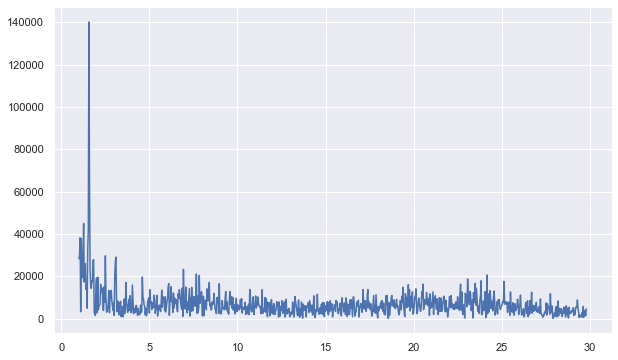

In [48]:
plt.plot(f, y)

## Testing peak-detection algorithm

In [ ]:
t0 = 0
nsteps = 10
window = 2

fooof_kwargs = {'min_peak_height': 0.2, 'verbose': True, 'peak_width_limits': (2, 5)}
# fm = FOOOF(**fooof_kwargs)

freq_range = [3, 17]
for t1 in np.arange(t0, t0 + nsteps):
    
    t2 = t1 + window
    lfp_test_5sec = lfp_test[t1*sf:t2*sf]

    f, y = get_psd(lfp_test_5sec, sf, freq_range=freq_range, log=False, smooth=True, sigma=1)
    
    y = zscore(y)
    
    peaks,_ = sig.find_peaks(y, prominence=0.1, width=1.5)
    
    #fm.fit(f, y, freq_range)
    #print("Peak params: ")
    #print(fm.peak_params_)
    #fm.report(f, y, freq_range)
    #plt.show()
    
    plt.plot(f, y, label=str(t1))
    plt.plot(f[peaks], y[peaks], "bo")
    plt.show()

## Testing tPAC

In [ ]:
%%time

fooof_kwargs = {'min_peak_height': 0.2, 'verbose': False, 'peak_width_limits': (2, 5)}

tpac_matrix, fp_dynamics, phase_dynamics = calculate_tpac(lfp_test, time_window=2, overlap=1.5, fp_range=(7, 17), **fooof_kwargs)

In [ ]:
plot_tpac_heatmap(tpac_matrix, smooth=True)

In [ ]:
tpac_matrix.shape

In [ ]:
fp_dynamics

In [ ]:
plot_heatmap(tpac_matrix, smooth=True, sigma=2)

In [ ]:
plot_heatmap(fp_dynamics, smooth=True, sigma=2)

In [ ]:
plt.plot(phase_dynamics)

## Testing tPAC on a surrogate coupled signal

In [89]:
sf = 2000
timepoints = np.arange(30 * sf)/sf
noise_level = 0.1

x1 = generate_coupled_signal(8, 250, 1, 0.1, 0.15, noise_level, timepoints)
x2 = generate_coupled_signal(20, 350, 1, 0.1, 0.1, noise_level, timepoints)

x = np.hstack((x1, x2))

### Signal

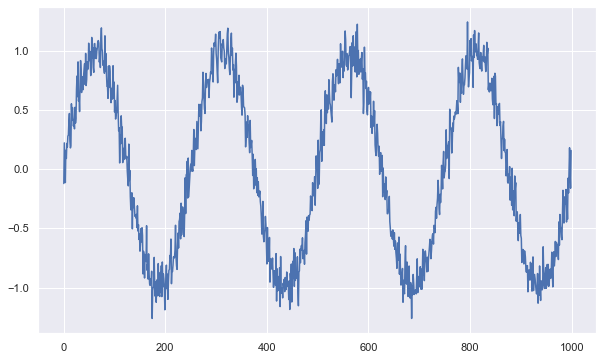

In [90]:
plt.plot(x1[:1000])

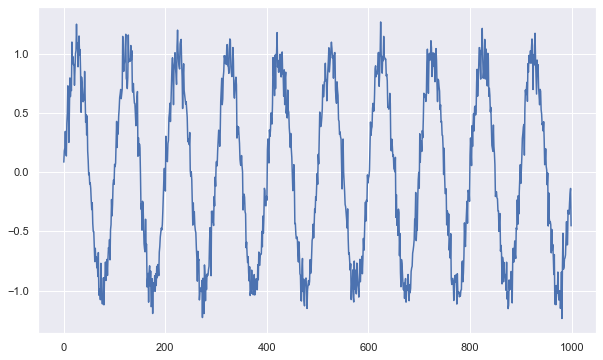

In [91]:
plt.plot(x2[:1000])

### Spectrum

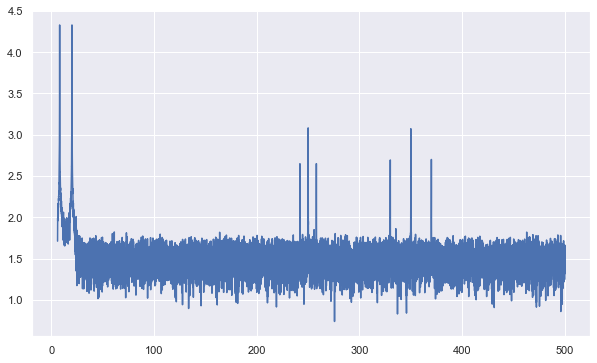

In [92]:
f, y = get_psd(x, sf, freq_range=[6, 500], log=True, smooth=True, sigma=1)

plt.plot(f, y)

### tPAC (Amplitude Frequency) Heatmap

timepoints:  120


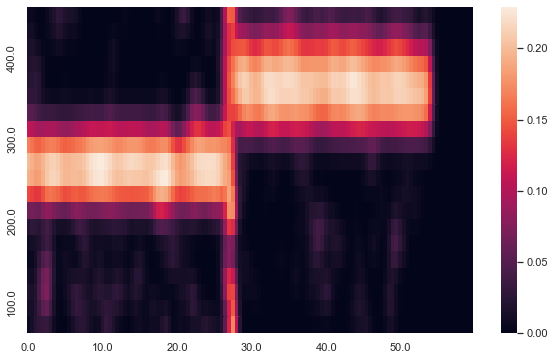

In [93]:
fooof_kwargs = {'min_peak_height': 0.2, 'verbose': True, 'peak_width_limits': (2, 5)}

tpac_matrix, fp_dynamics, phase_dynamics = calculate_tpac(x, time_window=2, overlap=1.5, fp_range=(7, 25), **fooof_kwargs);

plot_tpac_heatmap(tpac_matrix, smooth=True, sigma=1)

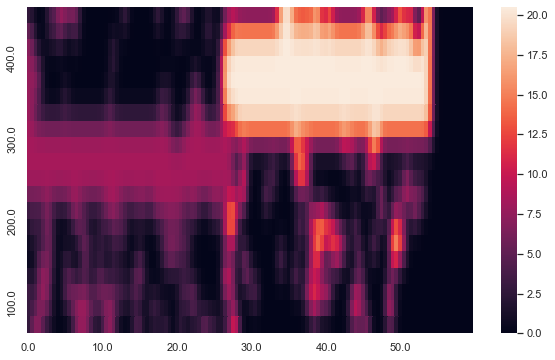

In [94]:
plot_tpac_heatmap(fp_dynamics, smooth=True, sigma=1)

### TensorPAC

Phase Amplitude Coupling object defined
    extract phases (n_pha=30) and amplitudes (n_amps=88)
    true PAC estimation using Modulation Index (MI, Tort et al. 2010)


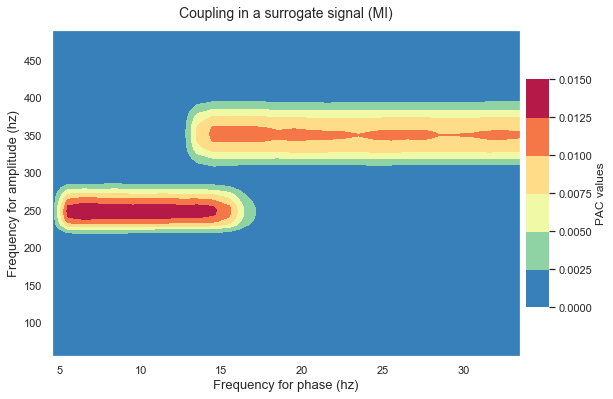

In [95]:
from tensorpac import Pac

sf = 2000.      # sampling frequency

data = x

# Define a Pac object
p = Pac(idpac=(2, 0, 0), f_pha=(4, 35, 1, 1), f_amp=(50, 500, 10, 5))
# Filter the data and extract pac
xpac = p.filterfit(sf, data)

p.comodulogram(xpac.mean(-1), cmap='Spectral_r', plotas='contour', ncontours=5,
               title='Coupling in a surrogate signal (MI)',
               fz_title=14, fz_labels=13)
p.show()

### Another surrogate (tensorPAC)

In [71]:
from tensorpac.signals import pac_signals_tort, pac_signals_wavelet

sf = 2000
n_times = 30 * sf

x1, time = pac_signals_tort(f_pha=8, f_amp=250, sf=sf, n_times=n_times, n_epochs=1, chi=0.1, noise=1)

x2, time = pac_signals_tort(f_pha=20, f_amp=350, sf=sf, n_times=n_times, n_epochs=1, chi=0.02, noise=1)

x = np.hstack((x1[0], x2[0]))

Phase Amplitude Coupling object defined
    extract phases (n_pha=30) and amplitudes (n_amps=88)
    true PAC estimation using Modulation Index (MI, Tort et al. 2010)


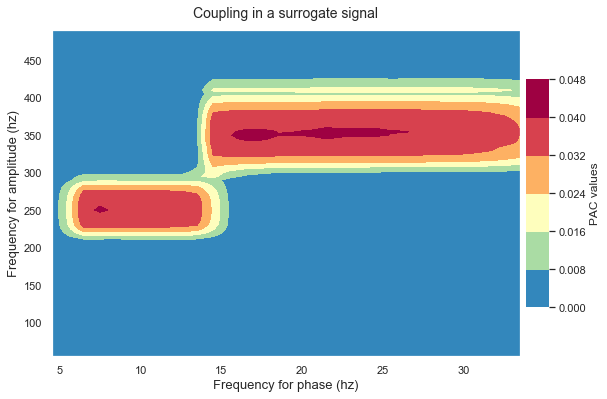

In [72]:
data = x

p = Pac(idpac=(2, 0, 0), f_pha=(4, 35, 1, 1), f_amp=(50, 500, 10, 5))

xpac = p.filterfit(sf, data)


p.comodulogram(xpac.mean(-1), cmap='Spectral_r', plotas='contour', ncontours=5,
               title='Coupling in a surrogate signal',
               fz_title=14, fz_labels=13)

p.show()

timepoints:  120


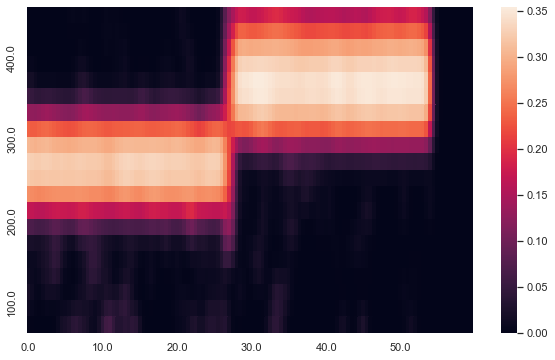

In [73]:
fooof_kwargs = {'min_peak_height': 0.2, 'verbose': True, 'peak_width_limits': (2, 5)}

tpac_matrix, fp_dynamics, phase_dynamics = calculate_tpac(x, time_window=2, overlap=1.5, fp_range=(7, 25), **fooof_kwargs);

plot_tpac_heatmap(tpac_matrix, smooth=True, sigma=1)

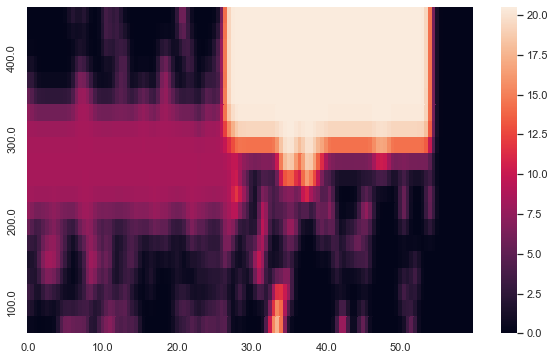

In [74]:
plot_tpac_heatmap(fp_dynamics, smooth=True, sigma=1)